# **Detecting Hospital Aquired Infections**

## Importing Libraries & Reading Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/predictionOfSepsis.csv"
# path= '/home/hossam/Downloads/AI Challenge/archive/predictionOfSepsis.csv'
df = pd.read_csv(path)

Mounted at /content/drive


## Data Exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552210 entries, 0 to 1552209
Data columns (total 44 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1552210 non-null  int64  
 1   Hour              1552210 non-null  int64  
 2   HR                1398811 non-null  float64
 3   O2Sat             1349474 non-null  float64
 4   Temp              525226 non-null   float64
 5   SBP               1325945 non-null  float64
 6   MAP               1358940 non-null  float64
 7   DBP               1065656 non-null  float64
 8   Resp              1313875 non-null  float64
 9   EtCO2             57636 non-null    float64
 10  BaseExcess        84145 non-null    float64
 11  HCO3              65028 non-null    float64
 12  FiO2              129365 non-null   float64
 13  pH                107573 non-null   float64
 14  PaCO2             86301 non-null    float64
 15  SaO2              53561 non-null    float64
 16  

In [ ]:
df.sample(5)

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
1224891,51,51,83.0,97.0,NaN,105.0,74.00,59.0,24.0,NaN,...,NaN,NaN,63.00,1,0.0,1.0,-239.81,52,0,115380
705446,17,17,86.0,100.0,NaN,146.0,101.33,NaN,17.0,NaN,...,NaN,69.0,51.67,1,1.0,0.0,-0.03,18,0,8818
821993,24,24,112.0,98.0,36.4,88.0,67.00,60.0,25.0,NaN,...,NaN,NaN,49.00,1,1.0,0.0,-3.67,25,0,100250
1405856,32,32,102.5,97.5,NaN,151.5,94.00,72.5,20.0,45.0,...,NaN,NaN,59.00,1,0.0,1.0,-13.20,33,0,109247
1183575,10,10,96.0,97.0,37.6,146.0,72.00,51.0,22.0,NaN,...,NaN,NaN,72.00,1,0.0,1.0,-146.00,11,0,119746


In [ ]:
patients = list(df['Patient_ID'].unique())
len(patients)

40336

In [ ]:
null_values = df.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
Bilirubin_direct,99.807371
Fibrinogen,99.340167
TroponinI,99.047745
Bilirubin_total,98.509158
Alkalinephos,98.393194
AST,98.377604
Lactate,97.329872
PTT,97.055875
SaO2,96.549372
EtCO2,96.286843


In [ ]:
def corr_matrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(40,40))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

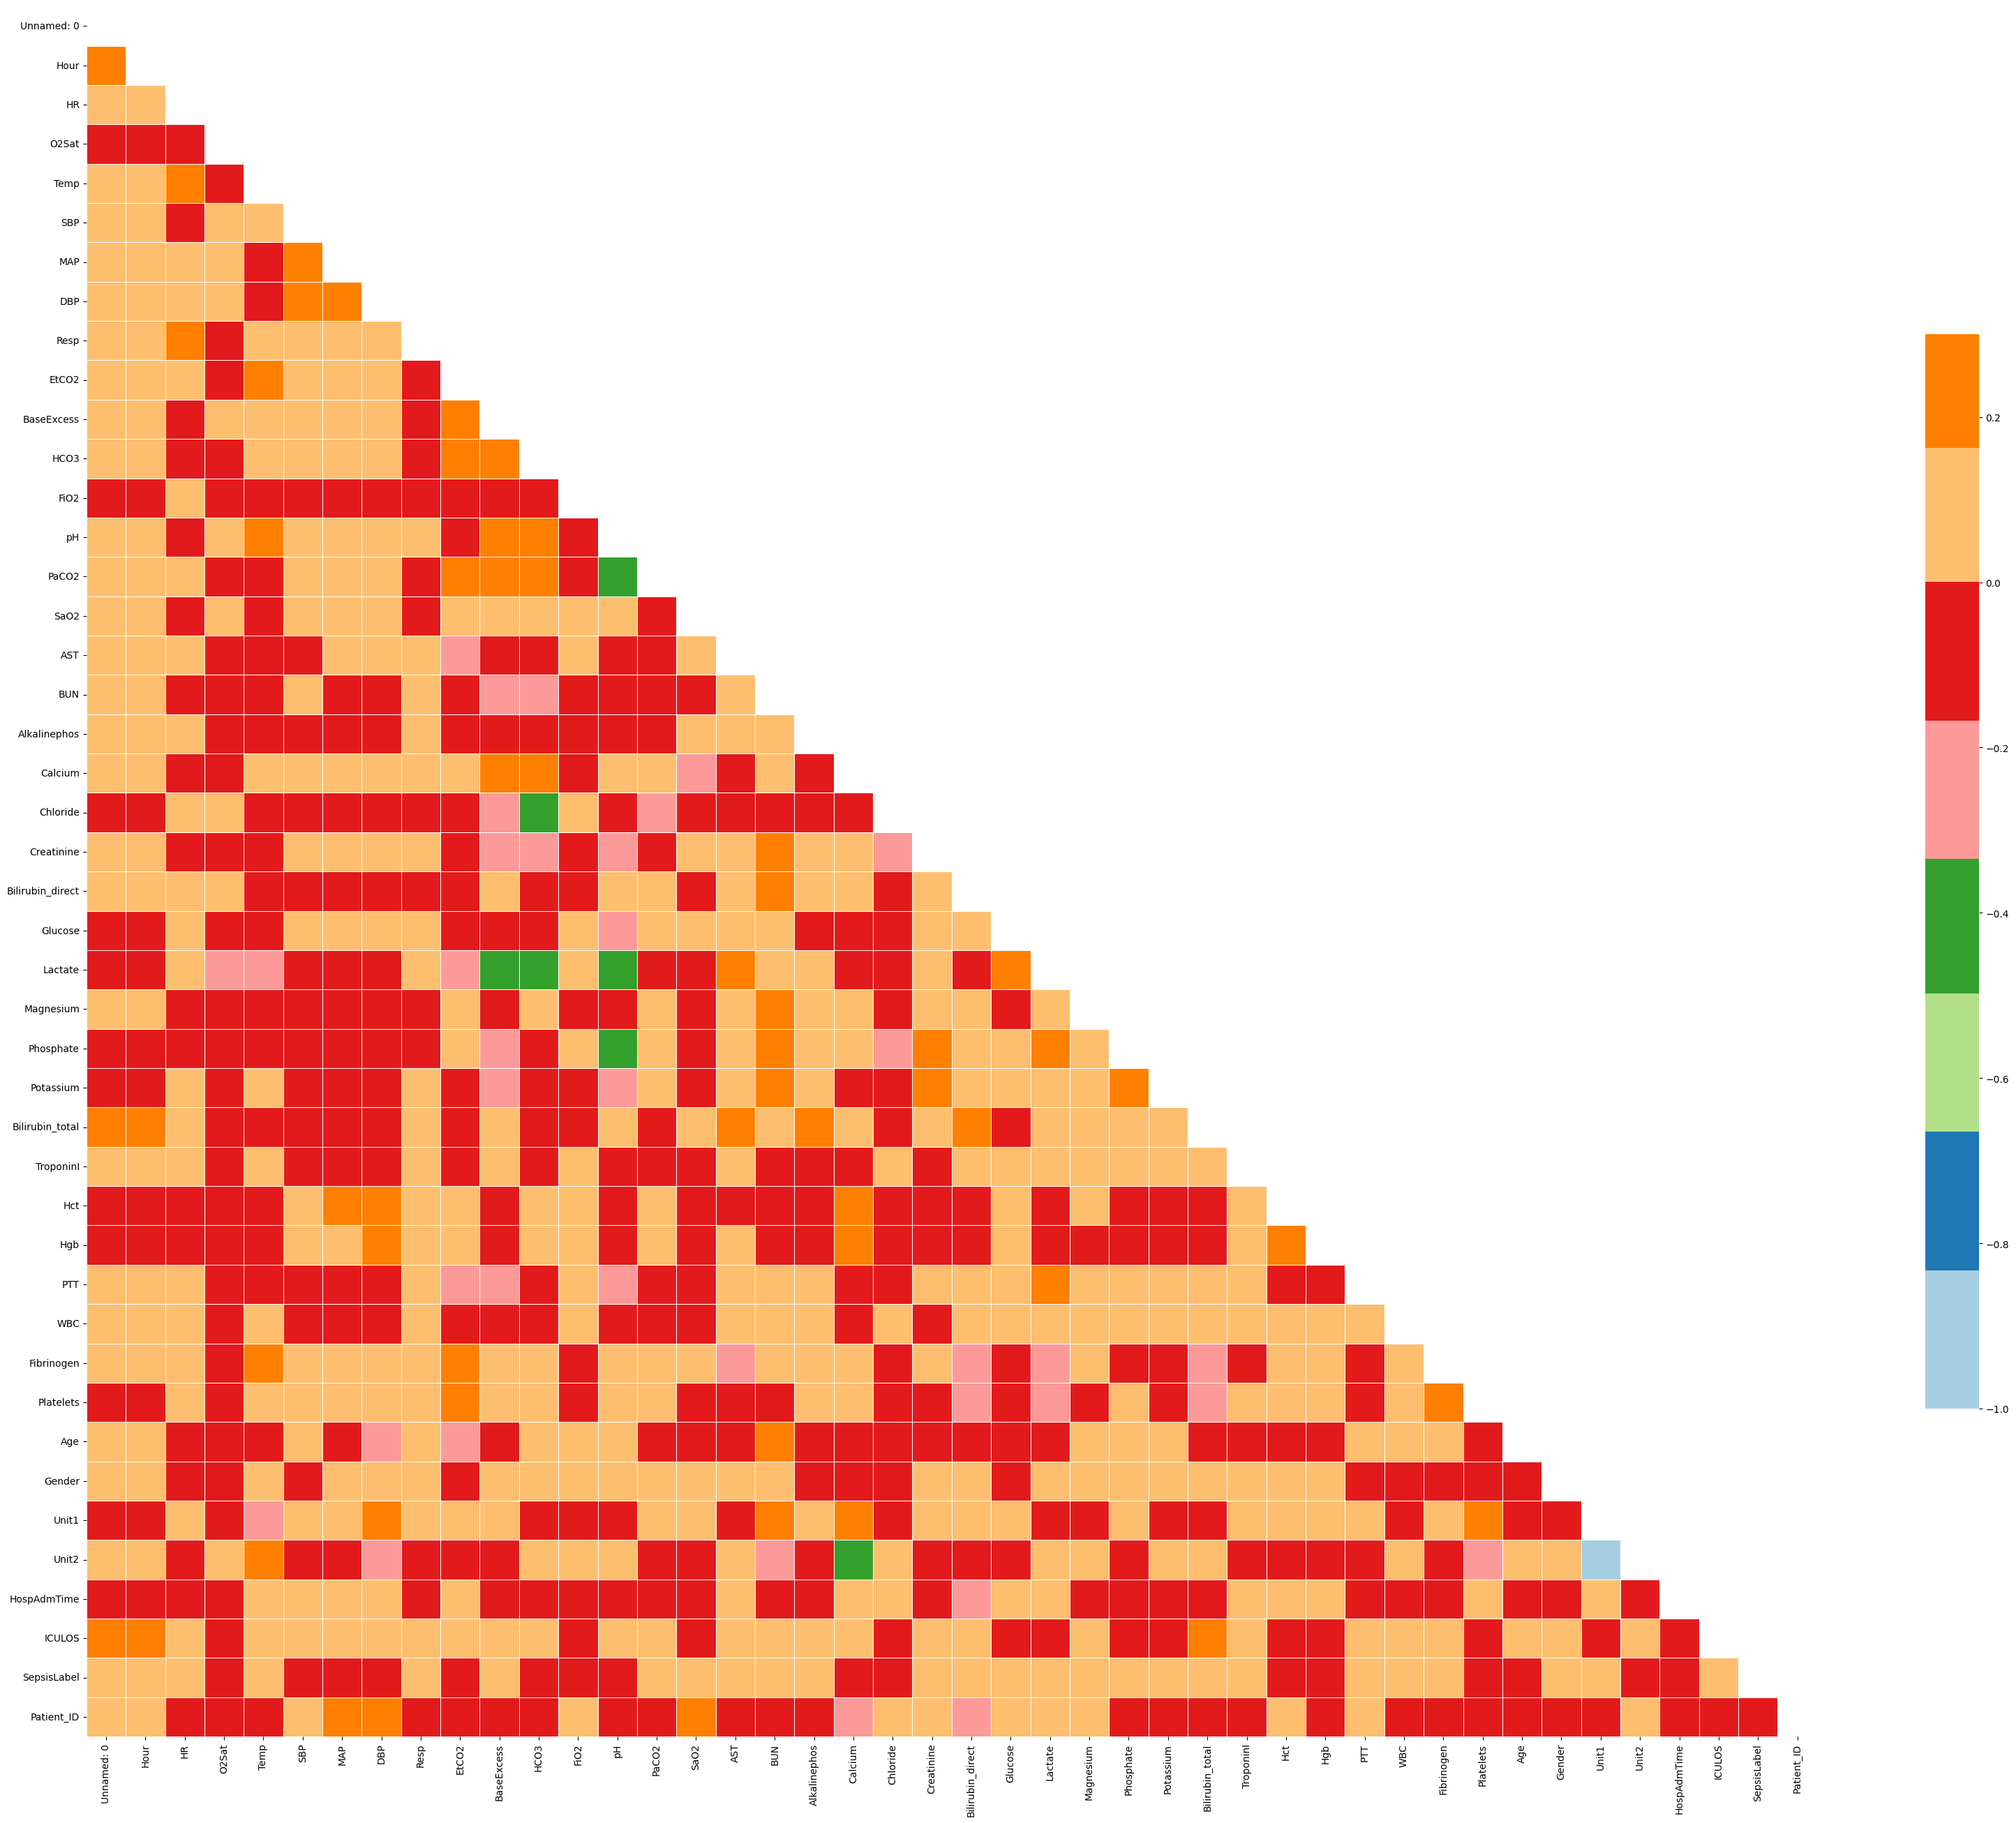

In [ ]:
corr_matrix(df)

# Data Cleaning & Filtering

In [ ]:
columns_to_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}

In [ ]:
df_new = df.assign(Unit=df['Unit1'] + df['Unit2'])
df_new = df_new.drop(columns=columns_to_drop)

In [ ]:
print(df_new.columns)
print(len(df_new.columns))

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'Patient_ID', 'Unit'],
      dtype='object')
28


In [ ]:
null_values = df_new.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
Bilirubin_direct,99.807371
TroponinI,99.047745
Bilirubin_total,98.509158
AST,98.377604
Lactate,97.329872
SaO2,96.549372
Chloride,95.460279
Platelets,94.059502
Creatinine,93.904433
WBC,93.593199


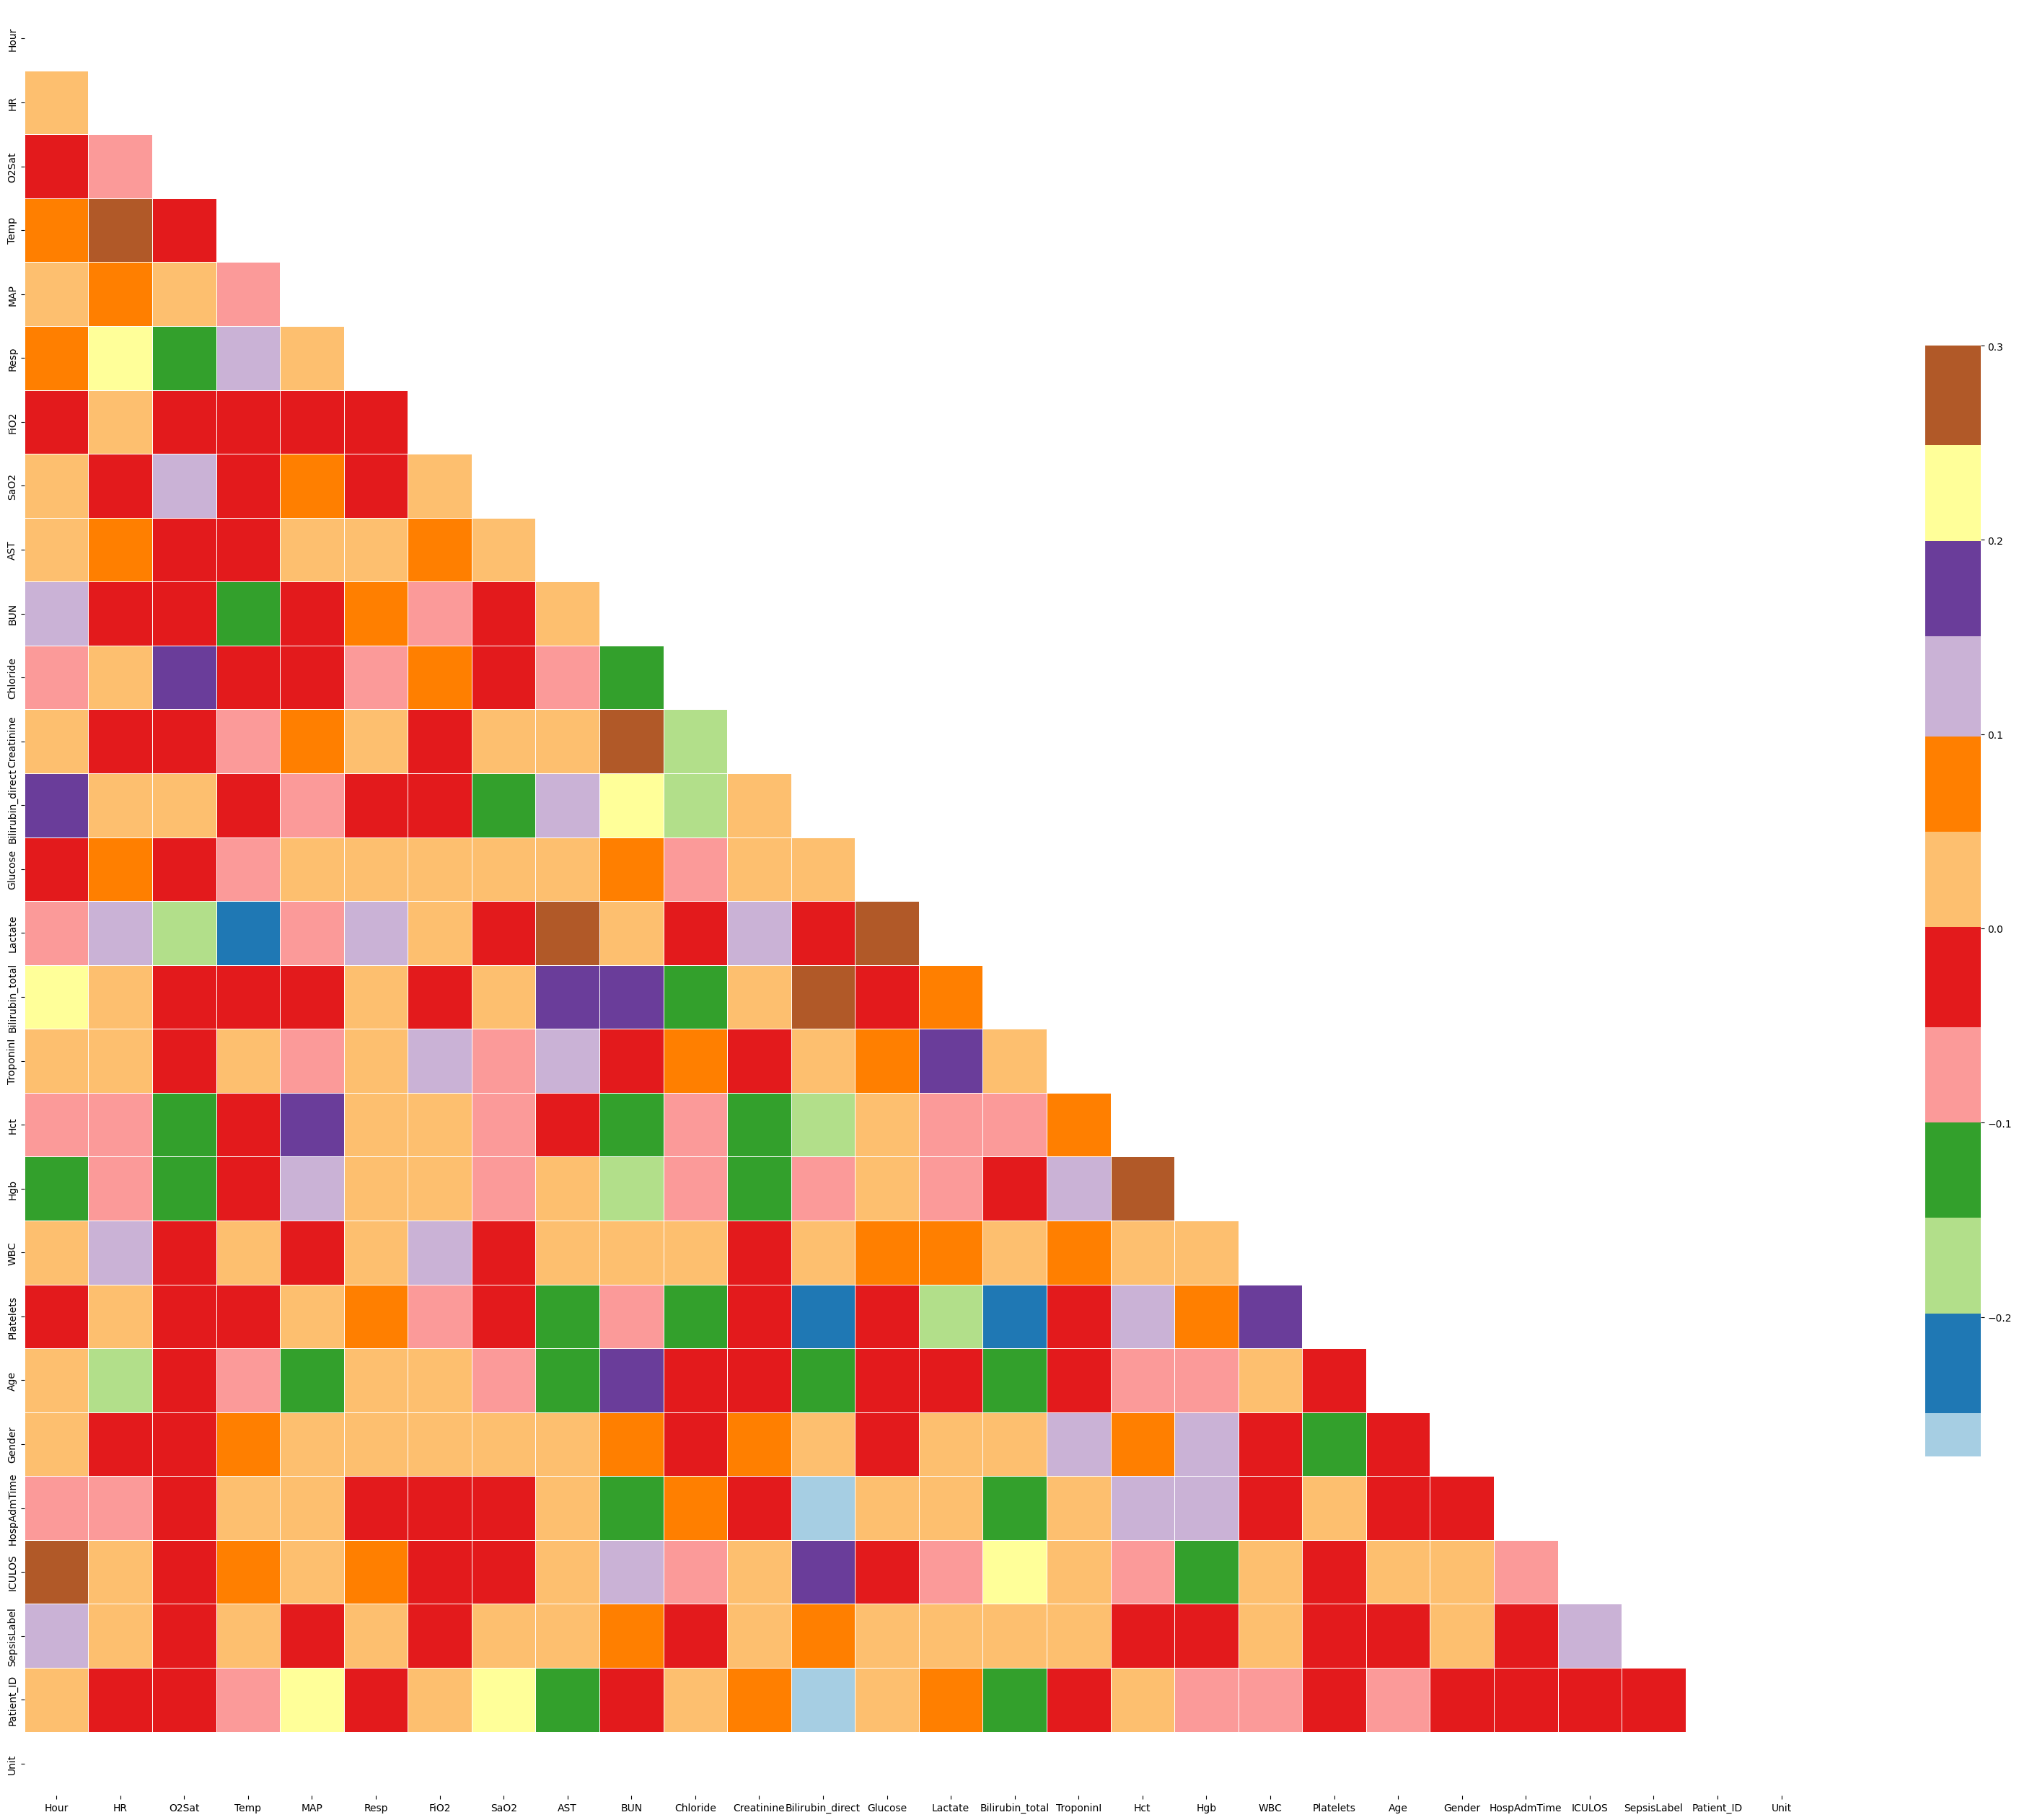

In [ ]:
corr_matrix(df_new)

In [ ]:
df_processed = df_new.copy()
grouped_by_patient = df_processed.groupby('Patient_ID')
df_processed_train = grouped_by_patient.apply(lambda x: x.bfill().ffill())

/tmp/ipython-input-1563898788.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_processed_train = grouped_by_patient.apply(lambda x: x.bfill().ffill())


In [ ]:
df_processed_train.head()

Hour     HR  O2Sat   Temp    MAP  Resp  FiO2  SaO2   AST  \
Patient_ID                                                                    
1          132940     0   97.0   95.0  36.11  75.33  19.0  0.28  88.0  16.0   
           132941     1   97.0   95.0  36.11  75.33  19.0  0.28  88.0  16.0   
           132942     2   89.0   99.0  36.11  86.00  22.0  0.28  88.0  16.0   
           132943     3   90.0   95.0  36.11  91.33  30.0  0.28  88.0  16.0   
           132944     4  103.0   88.5  36.11  91.33  24.5  0.28  88.0  16.0   

                    BUN  ...   Hgb  WBC  Platelets    Age  Gender  \
Patient_ID               ...                                        
1          132940  14.0  ...  12.5  5.7      317.0  83.14       0   
           132941  14.0  ...  12.5  5.7      317.0  83.14       0   
           132942  14.0  ...  12.5  5.7      317.0  83.14       0   
           132943  14.0  ...  12.5  5.7      317.0  83.14       0   
           132944  14.0  ...  12.5  5.7      317.0  83.14       0   

                   HospAdmTime  ICULOS  SepsisLabel  Patient_ID  Unit  
Patient_ID                                                             
1          132940        -0.03       1            0           1   NaN  
           132941        -0.03       2            0           1   NaN  
           132942        -0.03       3            0           1   NaN  
           132943        -0.03       4            0           1   NaN  
           132944        -0.03       5            0           1   NaN  

[5 rows x 28 columns]

In [ ]:
null_values = df_processed_train.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
Bilirubin_direct,93.266633
TroponinI,81.905412
Lactate,63.533607
SaO2,62.980589
Bilirubin_total,59.799447
AST,59.567520
FiO2,50.224390
Chloride,44.905329
Unit,39.425078
WBC,4.227456


In [ ]:
columns_drop_2 = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
            'Unit', 'Patient_ID']
df_processed_train = df_processed_train.drop(columns=columns_drop_2)
df_processed_train.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [ ]:
one_hot = pd.get_dummies(df_processed_train['Gender'])
df_processed_train = df_processed_train.join(one_hot)
df_processed_train = df_processed_train.drop('Gender', axis=1)

In [ ]:
null_values = df_processed_train.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
Chloride,44.905329
WBC,4.227456
Platelets,4.150598
Hgb,3.963317
Hct,3.786472
Creatinine,3.275459
BUN,3.233583
Glucose,2.708783
Temp,0.478672
MAP,0.173817


In [ ]:
df_processed_train = df_processed_train.dropna()

In [ ]:
null_values = df_processed_train.isnull().mean()*100
null_values

,0
Hour,0.0
HR,0.0
O2Sat,0.0
Temp,0.0
MAP,0.0
Resp,0.0
BUN,0.0
Chloride,0.0
Creatinine,0.0
Glucose,0.0


## Model Evaluation Metrics

In [ ]:
def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.show()

## Dataset Balance

In [ ]:
majority_class = df_processed_train[df_processed_train['SepsisLabel'] == 0]
minority_class = df_processed_train[df_processed_train['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))

number of sepsis label 1 is 17243
while number of sepsis label 0 is 823283


In [ ]:
majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_processed_train = pd.concat([majority_class_subset, minority_class])


In [ ]:
majority_class = df_processed_train[df_processed_train['SepsisLabel'] == 0]
minority_class = df_processed_train[df_processed_train['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))


number of sepsis label 1 is 17243
while number of sepsis label 0 is 34486


In [ ]:
df_processed_train[df_processed_train["SepsisLabel"] == 1].sample(5)


,,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,0,1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
18300,394119,35,97.0,93.0,38.44,71.0,23.0,15.0,108.0,0.70,168.0,30.5,10.2,17.5,257.0,88.28,-0.03,37,1,True,False
10627,201473,7,84.0,100.0,36.11,103.0,18.0,34.0,105.0,3.90,65.0,32.3,11.4,7.5,127.0,53.77,-85.89,8,1,False,True
19581,504898,16,85.0,99.0,37.22,72.0,23.0,8.0,105.0,0.60,124.0,28.5,9.1,19.4,294.0,72.52,-106.63,17,1,True,False
8522,720569,72,95.0,99.0,38.44,111.5,16.0,15.0,113.0,1.10,142.0,27.3,8.9,10.0,183.0,57.23,-0.02,74,1,False,True
117871,1131007,67,103.0,96.0,36.50,63.0,18.0,17.0,97.0,0.54,157.0,28.6,9.6,10.8,65.0,68.00,0.00,68,1,True,False


# Train / Test Split

In [ ]:
X = df_processed_train.drop('SepsisLabel', axis=1)
y = df_processed_train['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Model Fitting

## LogisticRegression

In [ ]:
lr_X_train=X_train.copy()
lr_X_test=X_test.copy()
lr_X_train.columns = X_train.columns.astype(str)
lr_X_test.columns = X_test.columns.astype(str)

In [ ]:
lr_model = LogisticRegression(random_state=42)

lr_model.fit(lr_X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

### Model Evaluation

In [ ]:
lr_pred = lr_model.predict(lr_X_test)
lr_prob = lr_model.predict_proba(lr_X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, lr_prob))
print(classification_report(y_test, lr_pred))


ROC-AUC: 0.7581405757935226
              precision    recall  f1-score   support

           0       0.75      0.94      0.84      6940
           1       0.75      0.37      0.50      3406

    accuracy                           0.75     10346
   macro avg       0.75      0.66      0.67     10346
weighted avg       0.75      0.75      0.72     10346



Accuracy: 0.7524647206649913
Precision: 0.7480916030534351
Recall: 0.37404580152671757
F1 Score: 0.49872773536895676
AUC-ROC: 0.6561151197835317
Mean Absolute Error: 0.2475352793350087
Root Mean Squared Error: 0.4975291743556439


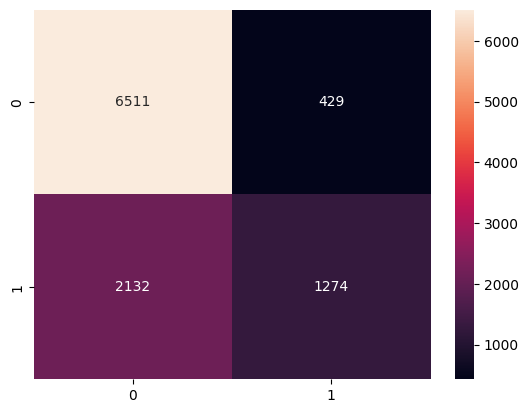

In [ ]:
evaluate_model(y_test,lr_pred)

## LGBMClassifier

In [ ]:
lgbm_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)

lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 13837, number of negative: 27546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3476
[LightGBM] [Info] Number of data points in the train set: 41383, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334364 -> initscore=-0.688511
[LightGBM] [Info] Start training from score -0.688511


LGBMClassifier(learning_rate=0.05, n_estimators=1000, random_state=42)

### Model Evaluation

In [ ]:
lgbm_pred = lgbm_model.predict(X_test)
lgbm_prob = lgbm_model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, lgbm_prob))
print(classification_report(y_test, lgbm_pred))


ROC-AUC: 0.978491761444882
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6940
           1       0.90      0.89      0.90      3406

    accuracy                           0.93     10346
   macro avg       0.93      0.92      0.92     10346
weighted avg       0.93      0.93      0.93     10346



Accuracy: 0.9329209356272956
Precision: 0.9026128266033254
Recall: 0.8925425719318849
F1 Score: 0.8975494537939179
AUC-ROC: 0.922640162046634
Mean Absolute Error: 0.06707906437270443
Root Mean Squared Error: 0.2589962632408129


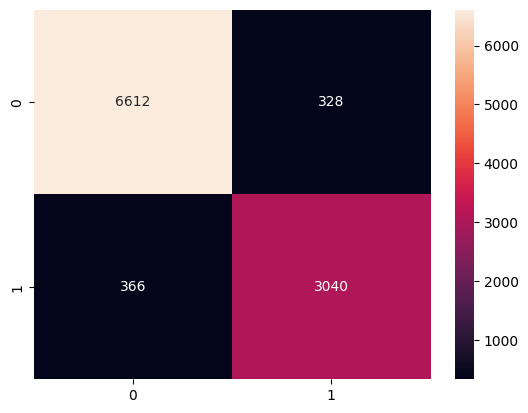

In [ ]:
evaluate_model(y_test,lgbm_pred)

## Random Forest Classifier

In [ ]:
rf_X_train=X_train.copy()
rf_X_test=X_test.copy()
rf_X_train.columns = X_train.columns.astype(str)
rf_X_test.columns = X_test.columns.astype(str)

In [ ]:
# rfc_model = RandomForestClassifier(n_estimators=100, random_state=0)
# rfc_model = RandomForestClassifier(n_estimators=200, random_state=0)
rfc_model = RandomForestClassifier(n_estimators=300, random_state=42)
rfc_model.fit(rf_X_train, y_train)
rcf_pred = rfc_model.predict(rf_X_test)

### Model Evaluation

Accuracy: 0.958438043688382
Precision: 0.9196277495769881
Recall: 0.9574280681150911
F1 Score: 0.9381472957422324
AUC-ROC: 0.9581808928471709
Mean Absolute Error: 0.04156195631161801
Root Mean Squared Error: 0.2038674969474487


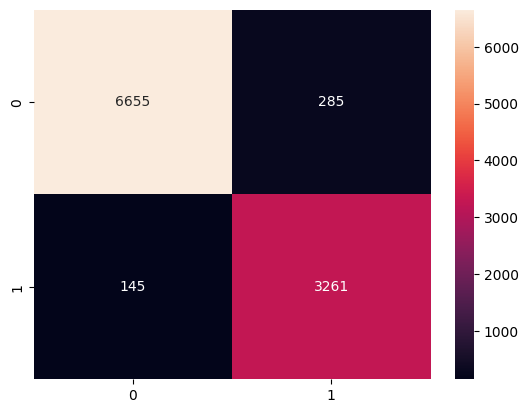

In [ ]:
evaluate_model(y_test,rcf_pred)

Confusion Matrix:
 [[6655  285]
 [ 145 3261]]


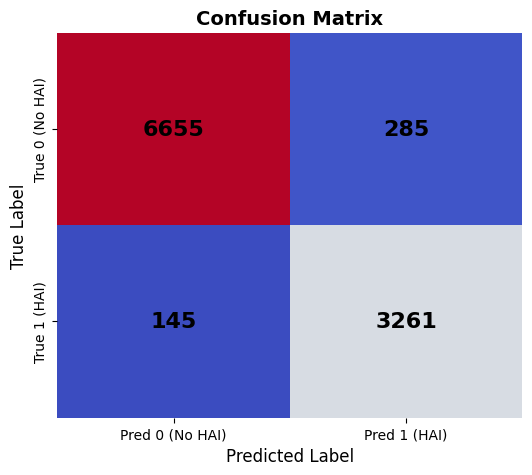

In [ ]:
cm = confusion_matrix(y_test, rcf_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False,
            xticklabels=["Pred 0 (No HAI)", "Pred 1 (HAI)"],
            yticklabels=["True 0 (No HAI)", "True 1 (HAI)"],
            annot_kws={"size":16, "weight":"bold", "color":"black"})
plt.title("Confusion Matrix", fontsize=14, weight="bold")
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.show()

# Most Effective Features

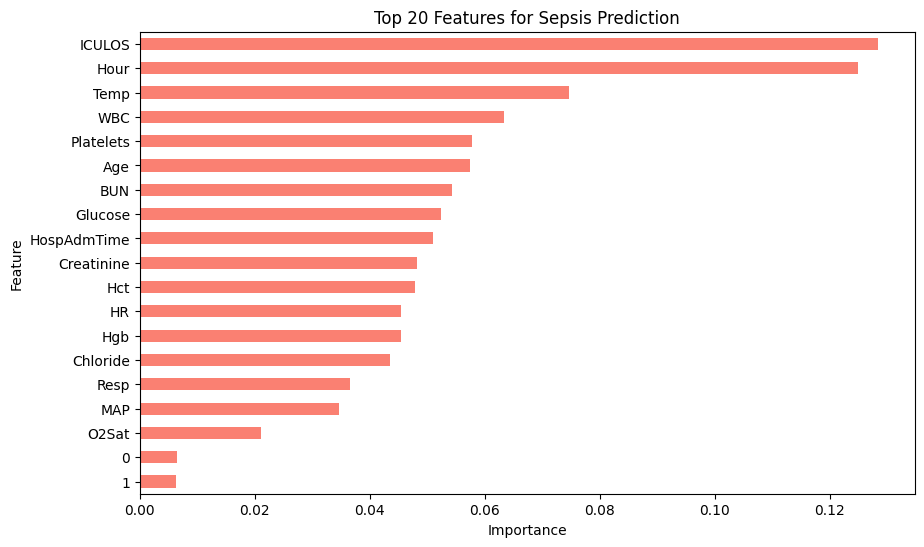

In [ ]:
importances = rfc_model.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

feat_imp.sort_values(by='Importance', ascending=True).head(20).plot(
    kind='barh',
    x='Feature',
    y='Importance',
    figsize=(10,6),
    color='salmon',
    legend=False
)
plt.xlabel("Importance")
plt.title("Top 20 Features for Sepsis Prediction")
plt.show()
